The agent should:

- Read incoming customer emails
- Classify them by urgency and topic
- Search relevant documentation to answer questions
- Draft appropriate responses
- Escalate complex issues to human agents
- Schedule follow-ups when needed

Example scenarios to handle:

1. Simple product question: "How do I reset my password?"
2. Bug report: "The export feature crashes when I select PDF format"
3. Urgent billing issue: "I was charged twice for my subscription!"
4. Feature request: "Can you add dark mode to the mobile app?"
5. Complex technical issue: "Our API integration fails intermittently with 504 errors"

## 定义我们的状态

In [1]:
from typing import TypedDict, Literal

# Define the structure for email classification
class EmailClassification(TypedDict):
    intent: Literal["question", "bug", "billing", "feature", "complex"]
    urgency: Literal["low", "medium", "high", "critical"]
    topic: str
    summary: str

class EmailAgentState(TypedDict):
    # Raw email data
    email_content: str
    sender_email: str
    email_id: str

    # Classification result
    classification: EmailClassification | None

    # Raw search/API results
    search_results: list[str] | None  # List of raw document chunks
    customer_history: dict | None  # Raw customer data from CRM

    # Generated content
    draft_response: str | None
    messages: list[str] | None

In [9]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

# 加载环境变量
load_dotenv(override=False)  # override=False 避免.env覆盖系统环境变量

llm = ChatOpenAI(
    model=os.getenv("MODEL_NAME"),
    temperature=0.5,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url=os.getenv("BASE_URL")
)

## 实现我们的电子邮件代理节点

#### 1、读取并分类节点

In [10]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.types import interrupt, Command, RetryPolicy
from langchain.messages import HumanMessage


def read_email(state: EmailAgentState) -> dict:
    """Extract and parse email content"""
    # In production, this would connect to your email service
    return {
        "messages": [HumanMessage(content=f"Processing email: {state['email_content']}")]
    }

def classify_intent(state: EmailAgentState) -> Command[Literal["search_documentation", "human_review", "draft_response", "bug_tracking"]]:
    """Use LLM to classify email intent and urgency, then route accordingly"""

    # Create structured LLM that returns EmailClassification dict
    structured_llm = llm.with_structured_output(EmailClassification)

    # Format the prompt on-demand, not stored in state
    classification_prompt = f"""
    Analyze this customer email and classify it:

    Email: {state['email_content']}
    From: {state['sender_email']}

    Provide classification including intent, urgency, topic, and summary.
    """

    # Get structured response directly as dict
    classification = structured_llm.invoke(classification_prompt)

    # Determine next node based on classification
    if classification['intent'] == 'billing' or classification['urgency'] == 'critical':
        goto = "human_review"
    elif classification['intent'] in ['question', 'feature']:
        goto = "search_documentation"
    elif classification['intent'] == 'bug':
        goto = "bug_tracking"
    else:
        goto = "draft_response"

    # Store classification as a single dict in state
    return Command(
        update={"classification": classification},
        goto=goto
    )

#### 2、搜索和跟踪节点

In [11]:
def search_documentation(state: EmailAgentState) -> Command[Literal["draft_response"]]:
    """Search knowledge base for relevant information"""

    # Build search query from classification
    classification = state.get('classification', {})
    query = f"{classification.get('intent', '')} {classification.get('topic', '')}"

    try:
        # Implement your search logic here
        # Store raw search results, not formatted text
        search_results = [
            "Reset password via Settings > Security > Change Password",
            "Password must be at least 12 characters",
            "Include uppercase, lowercase, numbers, and symbols"
        ]
    except SearchAPIError as e:
        # For recoverable search errors, store error and continue
        search_results = [f"Search temporarily unavailable: {str(e)}"]

    return Command(
        update={"search_results": search_results},  # Store raw results or error
        goto="draft_response"
    )

def bug_tracking(state: EmailAgentState) -> Command[Literal["draft_response"]]:
    """Create or update bug tracking ticket"""

    # Create ticket in your bug tracking system
    ticket_id = "BUG-12345"  # Would be created via API

    return Command(
        update={
            "search_results": [f"Bug ticket {ticket_id} created"],
            "current_step": "bug_tracked"
        },
        goto="draft_response"
    )

#### 3、响应节点

In [12]:
def draft_response(state: EmailAgentState) -> Command[Literal["human_review", "send_reply"]]:
    """Generate response using context and route based on quality"""

    classification = state.get('classification', {})

    # Format context from raw state data on-demand
    context_sections = []

    if state.get('search_results'):
        # Format search results for the prompt
        formatted_docs = "\n".join([f"- {doc}" for doc in state['search_results']])
        context_sections.append(f"Relevant documentation:\n{formatted_docs}")

    if state.get('customer_history'):
        # Format customer data for the prompt
        context_sections.append(f"Customer tier: {state['customer_history'].get('tier', 'standard')}")

    # Build the prompt with formatted context
    draft_prompt = f"""
    Draft a response to this customer email:
    {state['email_content']}

    Email intent: {classification.get('intent', 'unknown')}
    Urgency level: {classification.get('urgency', 'medium')}

    {chr(10).join(context_sections)}

    Guidelines:
    - Be professional and helpful
    - Address their specific concern
    - Use the provided documentation when relevant
    """

    response = llm.invoke(draft_prompt)

    # Determine if human review needed based on urgency and intent
    needs_review = (
        classification.get('urgency') in ['high', 'critical'] or
        classification.get('intent') == 'complex'
    )

    # Route to appropriate next node
    goto = "human_review" if needs_review else "send_reply"

    return Command(
        update={"draft_response": response.content},  # Store only the raw response
        goto=goto
    )

def human_review(state: EmailAgentState) -> Command[Literal["send_reply", END]]:
    """Pause for human review using interrupt and route based on decision"""

    classification = state.get('classification', {})

    # interrupt() must come first - any code before it will re-run on resume
    human_decision = interrupt({
        "email_id": state.get('email_id',''),
        "original_email": state.get('email_content',''),
        "draft_response": state.get('draft_response',''),
        "urgency": classification.get('urgency'),
        "intent": classification.get('intent'),
        "action": "Please review and approve/edit this response"
    })

    # Now process the human's decision
    if human_decision.get("approved"):
        return Command(
            update={"draft_response": human_decision.get("edited_response", state.get('draft_response',''))},
            goto="send_reply"
        )
    else:
        # Rejection means human will handle directly
        return Command(update={}, goto=END)

def send_reply(state: EmailAgentState) -> dict:
    """Send the email response"""
    # Integrate with email service
    print(f"Sending reply: {state['draft_response'][:100]}...")
    return {}

## 测试代理

In [13]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import RetryPolicy

# Create the graph
workflow = StateGraph(EmailAgentState)

# Add nodes with appropriate error handling
workflow.add_node("read_email", read_email)
workflow.add_node("classify_intent", classify_intent)

# Add retry policy for nodes that might have transient failures
workflow.add_node(
    "search_documentation",
    search_documentation,
    retry_policy=RetryPolicy(max_attempts=3)
)
workflow.add_node("bug_tracking", bug_tracking)
workflow.add_node("draft_response", draft_response)
workflow.add_node("human_review", human_review)
workflow.add_node("send_reply", send_reply)

# Add only the essential edges
workflow.add_edge(START, "read_email")
workflow.add_edge("read_email", "classify_intent")
workflow.add_edge("send_reply", END)

# Compile with checkpointer for persistence, in case run graph with Local_Server --> Please compile without checkpointer
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

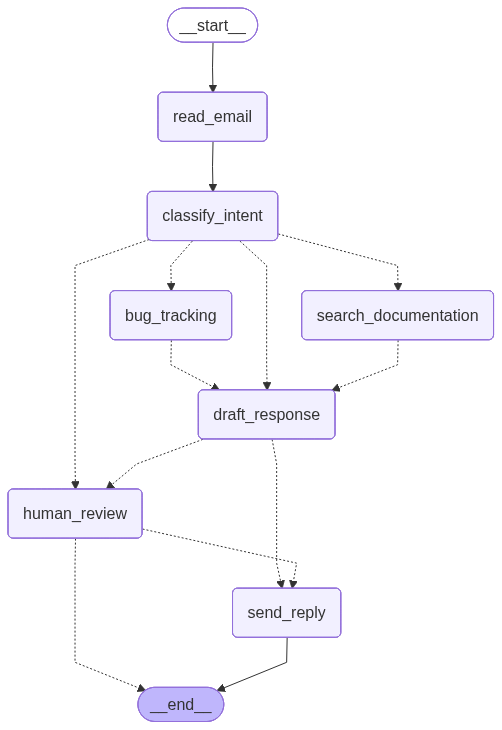

In [15]:
from IPython.display import Image, display
# Show the agent
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [14]:
# Test with an urgent billing issue
initial_state = {
    "email_content": "I was charged twice for my subscription! This is urgent!",
    "sender_email": "customer@example.com",
    "email_id": "email_123",
    "messages": []
}

# Run with a thread_id for persistence
config = {"configurable": {"thread_id": "customer_123"}}
result = app.invoke(initial_state, config)
# The graph will pause at human_review
print(f"human review interrupt:{result['__interrupt__']}")

# When ready, provide human input to resume
from langgraph.types import Command

human_response = Command(
    resume={
        "approved": True,
        "edited_response": "We sincerely apologize for the double charge. I've initiated an immediate refund..."
    }
)

# Resume execution
final_result = app.invoke(human_response, config)
print(f"Email sent successfully!")

human review interrupt:[Interrupt(value={'email_id': 'email_123', 'original_email': 'I was charged twice for my subscription! This is urgent!', 'draft_response': '', 'urgency': 'high', 'intent': 'billing', 'action': 'Please review and approve/edit this response'}, id='329c1637a68bad769849701551d77550')]
Sending reply: We sincerely apologize for the double charge. I've initiated an immediate refund......
Email sent successfully!
